# **HW 2 Problem 4 - Explainability with ShaRP**

# Explaining lending decisions using ShaRP

When multiple people apply for a loan, banks need to select who to fund. They do so by calculating how likely a person is to repay the loan and then select among the most likely. This process is a ranking process that ShaRP, a tool we saw in the lab, can explain.

To calculate feature importance, we will use ShaRP, a tool we've seen in the lab. For more information about the method, see the [full paper](https://arxiv.org/abs/2401.16744), and for more information about the toolkit see the [documentation](https://dataresponsibly.github.io/ShaRP/).

#1. Import Statements

First we install `ShaRP` and the necessary packages for this problem

In [2]:
# Data
!pip install folktables
# ShaRP
!pip install git+https://github.com/DataResponsibly/ShaRP.git

  Cloning https://github.com/DataResponsibly/ShaRP.git to /tmp/pip-req-build-co9ijors
  Running command git clone --filter=blob:none --quiet https://github.com/DataResponsibly/ShaRP.git /tmp/pip-req-build-co9ijors
  Resolved https://github.com/DataResponsibly/ShaRP.git to commit 7c7f698559af21eb854e769b03cac73bc2e39dd5
  Preparing metadata (setup.py) ... done
  Created wheel for xai-sharp: filename=xai_sharp-0.1.0-py3-none-any.whl size=41289 sha256=1648a4fc71c7e50ca5b2959e931530e3594f89b8e9dd7f846d452f3e91371a9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-qq9nmyhf/wheels/c5/7f/04/1a503d93dd4279042b196829ae106ea0025ccf8ea9791c97d3
Successfully built xai-sharp


In [3]:
#@markdown Import statments
from folktables import ACSDataSource, ACSIncome

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker

import seaborn as sns

import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sharp import ShaRP
from sharp.utils import scores_to_ordering

#2. Load Data

Next, we will load the ACSIncome dataset from the Folktables benchmark --- this is the same dataset used in Lab 2, 3 and 9.  Folktables is based from US Census Data and is built to solve a few simple prediction tasks. The sample we pull is data from 2018 in California. The column names are described in the table below. Note that certain categorical variables have been mapped to integer values, which we will keep as-is for the following analyses.

## Data profiling

| Column Name | Feature | Description/Notes |
| --- | ----------- | --- |
| PINCP | Total person’s income | (Target) 1 if >= $50k, 0 if less |
| SEX | Sex | (Sensitive Attribute) Male=1, Female=2 |
| RAC1P | Race | (Sensitive Attribute) White=1, Black=2, Other races are between 3 and 9 |
| AGEP | Age | Ranges from 0-99 |
| COW | Class of Worker | Ranges 1-9, see paper for description |
| SCHL | Education Level | Ranges 1-24, see paper for description |
| MAR | Marital Status | Ranges 1-5, see paper for description |
| OCCP | Occupation | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| POBP | Place of Birth | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| RELP | Relationship | Relationship of individual to person who responded to the Census taker. Ranges 0-17, see paper for description |
| WKHP | Hours worked per week | Ranges from 0-99, averaged over previous year |

In [4]:
#@markdown Import data
# data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
# acs_data = data_source.get_data(states=["CA"], download=True)

import gdown
# Replace with your actual file ID from the Google Drive link
file_id = '12fp-280VSQQimkZ7WmMBlrCwWlvsJVxJ'
# Construct the downloadable URL
url = f'https://drive.google.com/uc?id={file_id}'
# Download the file
gdown.download(url, 'downloaded_file.csv', quiet=False)
# Read the CSV file
acs_data = pd.read_csv('downloaded_file.csv')

features = ACSIncome.features
target_name = ACSIncome.target
data = acs_data.sample(1000, random_state=39)[features+list([target_name])]

print(data.shape)
data.head()

Downloading...
From (original): https://drive.google.com/uc?id=12fp-280VSQQimkZ7WmMBlrCwWlvsJVxJ
From (redirected): https://drive.google.com/uc?id=12fp-280VSQQimkZ7WmMBlrCwWlvsJVxJ&confirm=t&uuid=a6fd0f42-6a49-474f-9499-e0b12ed95858
To: /content/downloaded_file.csv
100%|██████████| 267M/267M [00:01<00:00, 259MB/s]


(1000, 11)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
123170,40,1.0,12.0,4,9640.0,303,0,40.0,2,8,6300.0
366093,40,3.0,16.0,5,5240.0,316,10,40.0,2,8,36000.0
279966,37,1.0,20.0,5,5000.0,303,5,NaN,2,1,0.0
206601,50,1.0,16.0,1,7700.0,206,1,56.0,1,6,48000.0
96394,26,7.0,19.0,5,7200.0,216,2,50.0,1,1,60000.0


## Preprocessing

Similarly to the explainability lab, we will be working with a limited number of features. We will also preprocess the data by dropping N/A columns and changing the type of features, as we did for this dataset in the labs.

In [5]:
#@markdown Drop rows with missing values
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 545 entries, 123170 to 242250
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    545 non-null    int64  
 1   COW     545 non-null    float64
 2   SCHL    545 non-null    float64
 3   MAR     545 non-null    int64  
 4   OCCP    545 non-null    float64
 5   POBP    545 non-null    int64  
 6   RELP    545 non-null    int64  
 7   WKHP    545 non-null    float64
 8   SEX     545 non-null    int64  
 9   RAC1P   545 non-null    int64  
 10  PINCP   545 non-null    float64
dtypes: float64(5), int64(6)
memory usage: 51.1 KB


In [6]:
# @markdown Count how many people we are ranking
population_size = data.shape[0]
print(population_size)

545


In [7]:
#@markdown Drop non-ordinal and some sensitive categorical features
non_ordinal_categorical_cols = ['COW','MAR','OCCP','POBP','RELP','SEX']
data.drop(columns=non_ordinal_categorical_cols, inplace=True)

In [8]:
#@markdown Change data types of categorical features and sensitive feature we will be using.
# @markdown Note that we will use SCHL as a numerical feature because it's ordinal
numerical_cols = ['AGEP','WKHP', 'SCHL']
categorical_cols = ['RAC1P']

for col in categorical_cols:
  data[col] = data[col].astype('int')
  data[col] = data[col].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 545 entries, 123170 to 242250
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   AGEP    545 non-null    int64   
 1   SCHL    545 non-null    float64 
 2   WKHP    545 non-null    float64 
 3   RAC1P   545 non-null    category
 4   PINCP   545 non-null    float64 
dtypes: category(1), float64(3), int64(1)
memory usage: 22.2 KB


In [9]:
#@markdown Standardize numerical features, we will use a min-max scaler because we use linear weighted functions
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data.head()

,AGEP,SCHL,WKHP,RAC1P,PINCP
123170,0.363636,0.478261,0.397959,8,6300.0
366093,0.363636,0.652174,0.397959,8,36000.0
206601,0.515152,0.652174,0.561224,6,48000.0
96394,0.151515,0.782609,0.500000,1,60000.0
232318,0.393939,0.869565,0.500000,9,55000.0


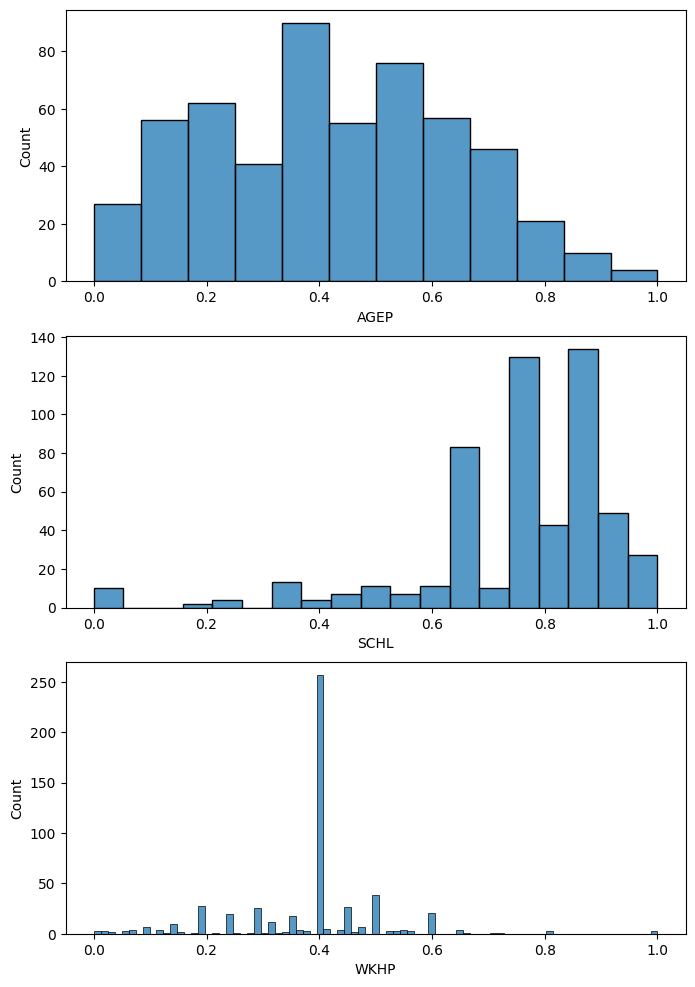

In [10]:
#@markdown Let's see how the distributions look after using the scaler
fig, ax = plt.subplots(3,1,figsize=(8,12))

ax[0] = sns.histplot(data=data, x="AGEP", ax=ax[0])
ax[1] = sns.histplot(data=data, x="SCHL", ax=ax[1])
ax[2] = sns.histplot(data=data, x="WKHP", ax=ax[2])

plt.show()

In [11]:
# @markdown View number of unique values per feature
for col in data.columns:
    print(col,": ",data[col].nunique())

AGEP :  62
SCHL :  20
WKHP :  48
RAC1P :  7
PINCP :  264


In [12]:
#@markdown Here we will drop the target variable as well because in our scenario
#@markdown we define our own target variables.
data.drop(columns=['PINCP'], inplace=True)

# Using ShaRP to calculate feature importance

## Different ranking functions

We will define three  ranking functions on Age, Work hours per week and education (`AGEP`, `SCHL`, `WKHP`). We use these features because we define numerical functions here and they are either continuous or ordinal categorical.

Note that each function places higher weight in one of the features.

In [13]:
#@markdown Define the scoring function and calculate the scores of all individuals
def score_function_SCHL(X):
    # AGEP, SCHL, WKHP
    return 0.2 * X[:, 0] + 0.6 * X[:, 1] + 0.2 * X[:, 2]

def score_function_WKHP(X):
    # AGEP, SCHL, WKHP
    return 0.2 * X[:, 0] + 0.2 * X[:, 1] + 0.6 * X[:, 2]

def score_function_AGEP(X):
    # AGEP, SCHL, WKHP
    return 0.6 * X[:, 0] + 0.2 * X[:, 1] + 0.2 * X[:, 2]

In [14]:
# @markdown Save the dataframe into a numpy array called X and calculate the
# @markdown target scores for all functions
X = data.to_numpy()
y_SCHL = score_function_SCHL(X)
y_WKHP = score_function_WKHP(X)
y_AGEP = score_function_AGEP(X)

## Define a ShaRP object for each function

We will use an approximation to calculate feature importance faster. To do so, we use the parameter `sample_size`. See the [QII paper](https://ieeexplore.ieee.org/document/7546525) for more details on the number of samples and approximation error.

In [15]:
# @markdown ShaRP object for the first (SCHL) score function
sharp_ranking_SCHL = ShaRP(
    qoi="rank",
    target_function=score_function_SCHL,
    measure="shapley",
    sample_size=150,
    replace=False,
    random_state=42,
)

sharp_ranking_SCHL.fit(X)

In [16]:
sharp_ranking_WKHP = ShaRP(
    qoi="rank",
    target_function=score_function_WKHP,
    measure="shapley",
    sample_size=150,
    replace=False,
    random_state=42,
)

sharp_ranking_WKHP.fit(X)

In [17]:
sharp_ranking_AGEP = ShaRP(
    qoi="rank",
    target_function=score_function_AGEP,
    measure="shapley",
    sample_size=150,
    replace=False,
    random_state=42,
)

sharp_ranking_AGEP.fit(X)

## Item order per function

The ranked order of the data points depends on the ranking function. Let's calculate the ranking defined by each function.

In [18]:
order_WKHP = scores_to_ordering(y_WKHP)
order_WKHP

array([406, 335,  63, 220,  88, 343, 182, 281, 342, 433, 541, 162, 377,
       376, 129, 324, 265, 216, 464, 362,  67,  98, 320, 138, 439, 521,
       185, 183, 421, 234, 127, 163, 530, 355, 476, 338, 472,  32, 214,
       363, 482,  49, 331, 461, 326, 542,  77, 354, 365, 516, 287, 471,
        48, 175, 434, 292, 350, 414,  65, 453, 490,  96, 117, 410, 534,
       479, 132, 347, 402, 274, 403, 148, 399, 248,  79, 407,  21, 366,
       361, 485, 269,  82, 493,  52, 114, 416, 202, 337, 252, 298, 211,
       405, 255, 305, 290, 261, 459,  15,  28, 522,  29, 455, 257, 469,
       119, 207,  25, 346,  34, 307, 378, 514, 180, 451, 495, 263,  19,
        17, 386, 311, 474, 246, 396, 391,  69, 371, 155, 120, 204, 124,
       158, 141,  75, 392,  47, 369, 126,   4, 533, 169, 425, 236,   6,
        51, 196,  24, 221, 519, 226, 520, 273, 348, 341, 432, 336, 208,
       452,  14, 467, 529, 528, 325, 508,  53, 487, 195, 382, 454, 201,
       418, 470, 353, 134,  43,  39, 254,  35,  61, 477, 267, 17

In [19]:
# @markdown Order of data points based on the first scoring function
order_SCHL = scores_to_ordering(y_SCHL)
order_SCHL

array([493, 426, 324, 333, 129, 450, 114, 237, 536, 487, 523, 172, 509,
       526, 100, 185, 226, 387, 117, 250,  41, 403, 264,  30, 357, 320,
       229, 113, 460, 231, 134, 127, 396, 388, 538, 503, 521,  73, 143,
       520, 420, 317, 274, 532, 371, 465,  95, 126, 504, 390, 347, 416,
        78, 103, 469, 313, 432, 472,  37, 443, 485,  97,  88, 519, 479,
       535, 145, 283, 338, 365, 244, 299, 288, 171, 361, 449,  21, 359,
       241, 246, 121, 110, 507,  27, 177, 455, 175, 407, 346, 495, 182,
       414, 266, 254, 311, 181, 151,  57, 104, 488,  56, 364, 280, 458,
       168,  58,  23, 285,  31, 116, 404, 441, 147, 478, 415, 391,  36,
        25, 289, 222, 537, 309, 444, 442,  18, 517,  82, 135, 123, 176,
       236, 187, 234, 392,   7, 249, 190,  13, 541, 245, 463, 197,  10,
        53, 124,  39, 259, 525, 224, 545, 399, 284, 300, 326, 425, 348,
       529,  16, 501, 440, 412, 421, 476, 291, 335, 192, 186, 169, 178,
       281, 527, 434, 109,  54,   8, 318,  14, 164, 518, 191, 32

In [20]:
order_AGEP = scores_to_ordering(y_AGEP)
order_AGEP

array([386, 343, 178, 431, 228, 306, 236, 383, 324, 482, 543, 290, 241,
       512, 136, 225, 358, 251,  21, 255, 107, 374, 424, 213,  48, 353,
       174, 237, 489, 283, 108, 176, 493, 405, 335, 449, 499, 190, 301,
       170, 505, 181, 439, 450, 380, 531, 169, 182, 242, 509, 434, 501,
        62, 223, 510, 349, 368, 274,  95, 393, 508, 151, 111, 339, 536,
       461, 121, 458, 454, 153, 419,  52, 337, 351, 161, 465,  49, 437,
       124, 238, 207,  23, 126, 149, 315, 483, 266, 369, 231, 128, 284,
       441,  38, 401, 346, 361,  58, 112,  13, 528, 171, 471, 291, 452,
       295, 117,  16, 457,  31,  71, 435, 523, 211, 525, 479, 229,  79,
        89, 127, 425, 318, 249, 433, 417,  40, 338, 187, 219,  42,  81,
       103, 106, 277, 484,  12, 137, 340,   1, 387, 118, 495, 298,   3,
       100, 268,  20, 233, 448, 264, 541, 261, 456, 296, 302, 342, 148,
       428,  35, 519, 500, 517, 325, 475, 226, 276,  85, 202, 204, 150,
       410, 481, 367, 145,  36,   5, 263,   2, 116, 518, 384,  9

## Item explainability for multiple functions

Now we will select the person ranked 100th using the first function, and explain their featre importance under ALL functions

## TODO: Part (a)

### Part (i)

In [21]:
# Part (a)(i) - What is the rank of individual i in the rankings based on other functions

# Select the 100th ranked individual according to sharp_ranking_SCHL
i100 = order_SCHL[99]  # 0-indexed, so 99 is the 100th position
print(f"Individual at rank 100 in SCHL ranking is index: {i100}")

# Find that individual's rank according to sharp_ranking_WKHP
rankInWKHP = np.where(order_WKHP == i100)[0][0] + 1
print(f"This individual's rank in WKHP ranking: {rankInWKHP}")

# Find that individual's rank according to sharp_ranking_AGEP
rankInAGEP = np.where(order_AGEP == i100)[0][0] + 1
print(f"This individual's rank in AGEP ranking: {rankInAGEP}")

# Do the above for another individual (using 200th ranked individual)
i200 = order_SCHL[199]  # 0-indexed, so 199 is the 200th position
rank200InWKHP = np.where(order_WKHP == i200)[0][0] + 1
rank200InAGEP = np.where(order_AGEP == i200)[0][0] + 1

print(f"Individual at rank 200 in SCHL ranking is index: {i200}")
print(f"This individual's rank in WKHP ranking: {rank200InWKHP}")
print(f"This individual's rank in AGEP ranking: {rank200InAGEP}")

Individual at rank 100 in SCHL ranking is index: 488
This individual's rank in WKHP ranking: 521
This individual's rank in AGEP ranking: 489
Individual at rank 200 in SCHL ranking is index: 522
This individual's rank in WKHP ranking: 100
This individual's rank in AGEP ranking: 356


### Part (ii)

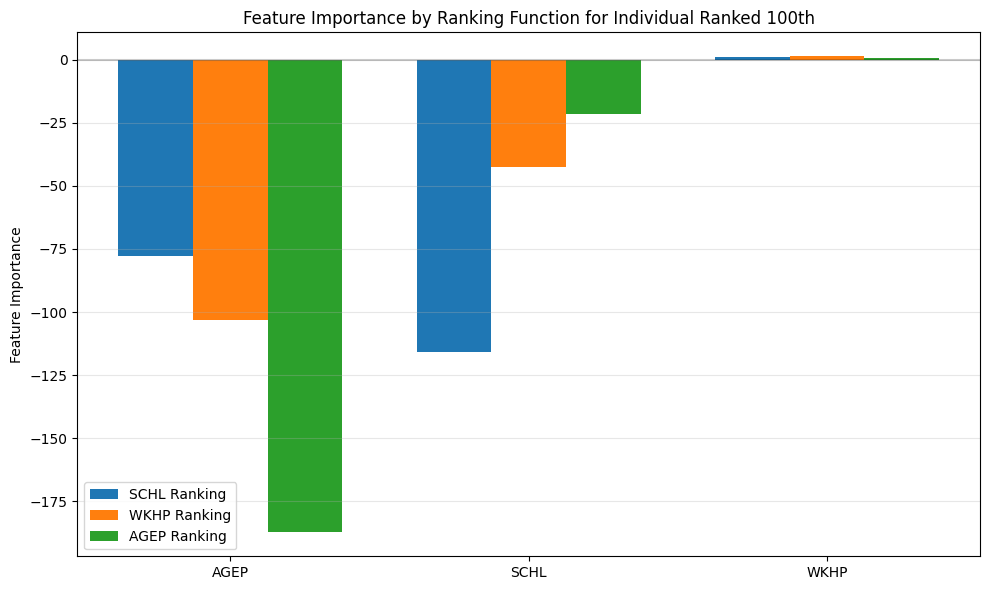


Feature importance values for individual ranked 100th:
SCHL ranking function: {'AGEP': np.float64(-77.64555555555556), 'SCHL': np.float64(-115.97333333333333), 'WKHP': np.float64(0.8322222222222222)}
WKHP ranking function: {'AGEP': np.float64(-103.34333333333333), 'SCHL': np.float64(-42.39888888888889), 'WKHP': np.float64(1.3377777777777782)}
AGEP ranking function: {'AGEP': np.float64(-187.31333333333333), 'SCHL': np.float64(-21.75444444444444), 'WKHP': np.float64(0.6588888888888889)}


In [31]:
# Part (a)(ii) - Compute the importance of i according to rank QoI for each of the 3 rankings

# Define consistent feature names used in all models
feature_names = ['AGEP', 'SCHL', 'WKHP']

# Reconstruct the feature matrix
X = data[feature_names].to_numpy()

# Refit all ShaRP models before explaining
sharp_ranking_SCHL.fit(X)
sharp_ranking_WKHP.fit(X)
sharp_ranking_AGEP.fit(X)

# Get the index of the 100th ranked individual
i100 = order_SCHL[99]  # assuming 0-indexed and ranked by SCHL

# Get contributions for the individual ranked 100th under each scoring function
all_explanations_SCHL = sharp_ranking_SCHL.all(X)
contributions_SCHL = all_explanations_SCHL[i100]

all_explanations_WKHP = sharp_ranking_WKHP.all(X)
contributions_WKHP = all_explanations_WKHP[i100]

all_explanations_AGEP = sharp_ranking_AGEP.all(X)
contributions_AGEP = all_explanations_AGEP[i100]

# Create a comparison plot
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(feature_names))
width = 0.25

rects1 = ax.bar(x - width, contributions_SCHL, width, label='SCHL Ranking')
rects2 = ax.bar(x, contributions_WKHP, width, label='WKHP Ranking')
rects3 = ax.bar(x + width, contributions_AGEP, width, label='AGEP Ranking')

ax.set_ylabel('Feature Importance')
ax.set_title('Feature Importance by Ranking Function for Individual Ranked 100th')
ax.set_xticks(x)
ax.set_xticklabels(feature_names)
ax.legend()
ax.axhline(y=0, color='k', linestyle='-', alpha=0.2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print the values for reference
print("\nFeature importance values for individual ranked 100th:")
print(f"SCHL ranking function: {dict(zip(feature_names, contributions_SCHL))}")
print(f"WKHP ranking function: {dict(zip(feature_names, contributions_WKHP))}")
print(f"AGEP ranking function: {dict(zip(feature_names, contributions_AGEP))}")


## TODO: Part (b)

### Part (i)

Now we will calculate the feature importances based on groups defined by the sensitive attribute. We will select one ranking function for this question and calculate the rank QoI feature importances for the top 20%.

In [25]:
# @markdown Add the rank to the dataframe
data['RANK'] = order_SCHL

data.head()

,AGEP,SCHL,WKHP,RAC1P,RANK
123170,0.363636,0.478261,0.397959,8,493
366093,0.363636,0.652174,0.397959,8,426
206601,0.515152,0.652174,0.561224,6,324
96394,0.151515,0.782609,0.500000,1,333
232318,0.393939,0.869565,0.500000,9,129


In [26]:
# # @markdown Function that will split feature explanations into different strata.
# # @markdown For this question we only look at the top 20% and plot the conributions
# # @markdown in 10% strata.

# Note that s is the ranks of the individuals (you can find this using the scores_to_ordering utility function, see Lab 8 for an example)
def make_boxplot_top20(df, X, s):
  buckets = 2
  rows = max(s)
  df['My Rank'] = s
  df['Rank Bucket'] = ["0-\n10%" if math.floor((rank - 1) / (rows / buckets)) == 0 else str(math.floor((rank - 1) / (rows / buckets)) * 10) + "-\n" + str(math.floor(((rank - 1) / (rows / buckets)) + 1) * 10) + "%" for rank in df['My Rank']]
  df.sort_values(by=['Rank Bucket'],inplace=True)
  yaxis_order = list(df.sort_values(by=['Rank Bucket'])['Rank Bucket'].unique())

  df = (
      df
      .drop(columns=["My Rank"])
      .melt(id_vars=["Rank Bucket"])
      .rename(columns={"variable": "Feature", "value": "Contribution"})
  )

  plot_df = df.copy()

  plot_df["Rank Bucket"] = plot_df["Rank Bucket"].str.replace("%", "\%").str.replace("<", "$<$")

  graph = sns.boxplot(x = plot_df['Rank Bucket'], y = plot_df['Contribution'], hue = plot_df['Feature'], palette = "Set2")
  sns.move_legend(
      graph, "lower center", bbox_to_anchor=(1, 1.05), ncol=4, title=None, frameon=False, labels=["AGEP",'WKHP',"SCHL"]
  )
  plt.setp(graph.patches, linewidth=1)
  graph.set_xlabel("Rank stratum\n(a)")

  plt.show()

Below is a usage example for this function given an X and y as they are created in this assignment:


```
# NEW
sharp_ranking_SCHL_not_white = ShaRP(
    qoi="rank",
    target_function=score_function_SCHL,
    measure="shapley",
    sample_size=None,
    replace=False,
    random_state=42,
)
X = data_non_white.drop(columns=['RAC1P', 'RANK']).to_numpy()
ranks = data_non_white['RANK'].to_numpy()
sharp_ranking_SCHL_not_white.fit(X)
df = pd.DataFrame(sharp_ranking_SCHL_not_white.all(X))
make_boxplot_top20(df,X, ranks)
```



In [27]:
# Part (b)(i) - Split the top-20% into two new dataframes (white and non-white) using the race feature

# Calculate the number of individuals that represent the top 20%
top_20_percent = int(0.2 * data.shape[0])
print(f"Top 20% consists of {top_20_percent} individuals")

# Get the indices of the top 20% ranked individuals
top_20_indices = order_SCHL[:top_20_percent]

# Create dataframe with only the top 20% individuals
data_top_20 = data.iloc[top_20_indices].copy()

# Split by race (race code 1 is White)
data_white = data_top_20[data_top_20['RAC1P'] == 1].copy()
data_non_white = data_top_20[data_top_20['RAC1P'] != 1].copy()

print(f"Number of white individuals in top 20%: {len(data_white)}")
print(f"Number of non-white individuals in top 20%: {len(data_non_white)}")

# Create a ShaRP object for the white dataframe
sharp_ranking_SCHL_white = ShaRP(
    qoi="rank",
    target_function=score_function_SCHL,
    measure="shapley",
    sample_size=None,  # No approximation needed for small samples
    replace=False,
    random_state=42,
)

# Prepare data for white group
X_white = data_white.drop(columns=['RAC1P', 'RANK']).to_numpy()
ranks_white = data_white['RANK'].to_numpy()
sharp_ranking_SCHL_white.fit(X_white)

# Create a ShaRP object for the non-white dataframe
sharp_ranking_SCHL_non_white = ShaRP(
    qoi="rank",
    target_function=score_function_SCHL,
    measure="shapley",
    sample_size=None,  # No approximation needed for small samples
    replace=False,
    random_state=42,
)

# Prepare data for non-white group
X_non_white = data_non_white.drop(columns=['RAC1P', 'RANK']).to_numpy()
ranks_non_white = data_non_white['RANK'].to_numpy()
sharp_ranking_SCHL_non_white.fit(X_non_white)


Top 20% consists of 109 individuals
Number of white individuals in top 20%: 57
Number of non-white individuals in top 20%: 52


### Part (ii)

Top 20% consists of 109 individuals
Number of white individuals in top 20%: 57
Number of non-white individuals in top 20%: 52


<Figure size 1200x800 with 0 Axes>

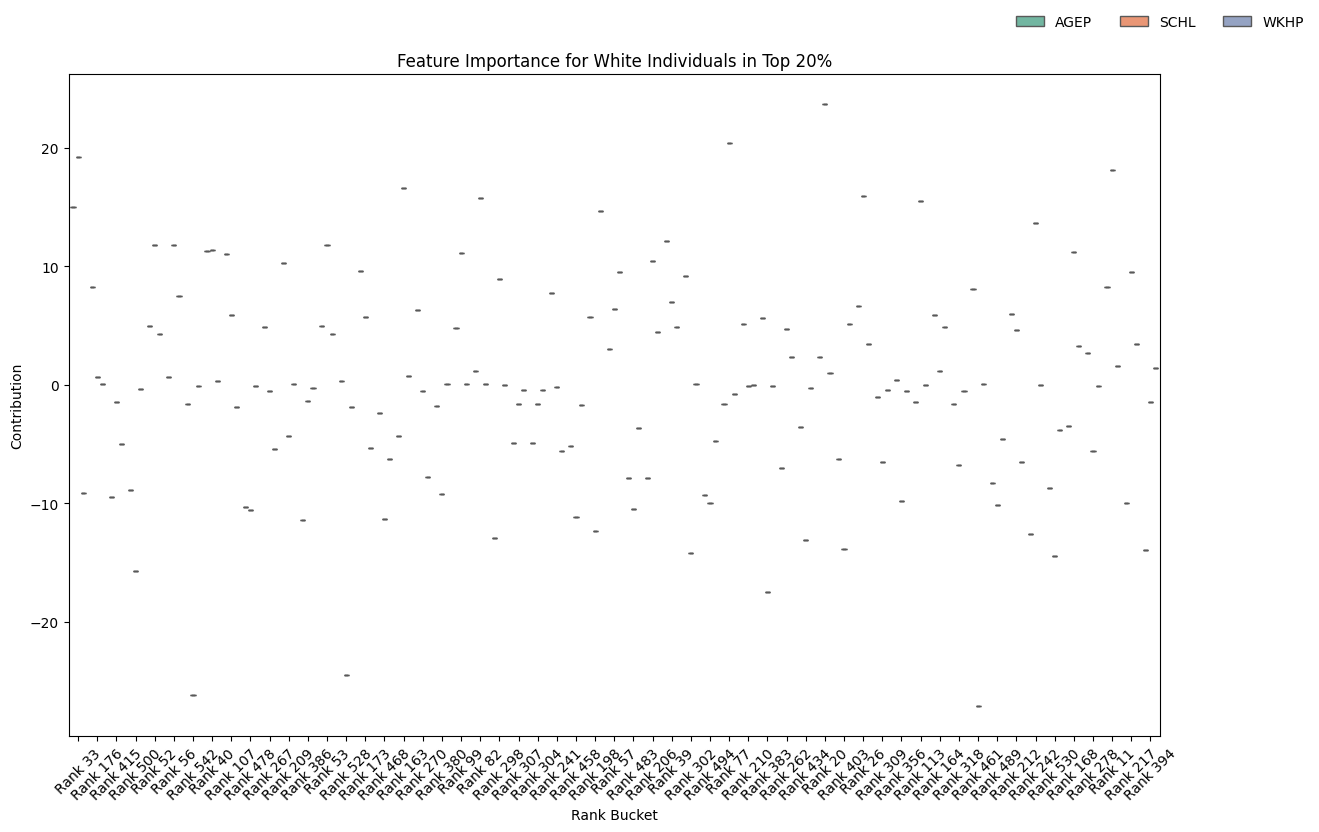

<Figure size 640x480 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

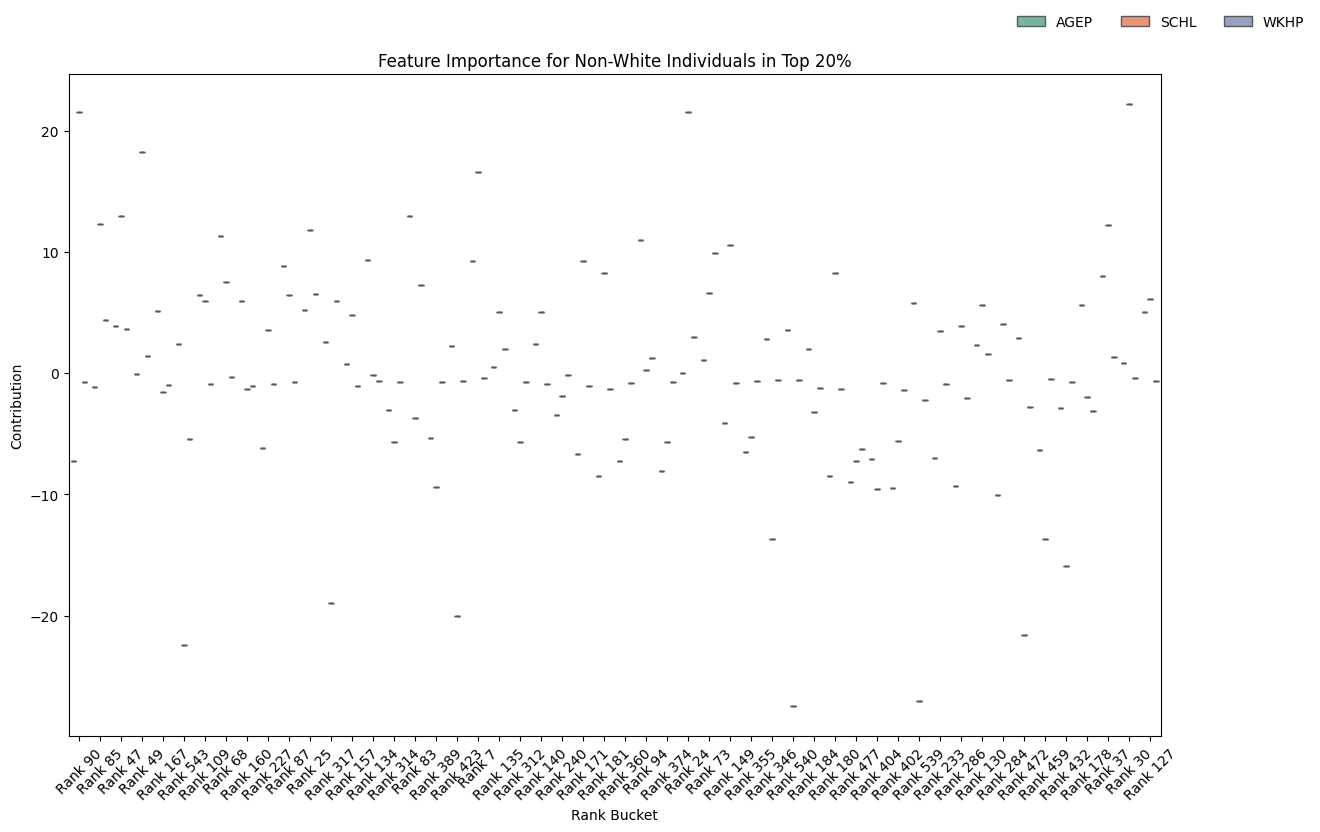

<Figure size 640x480 with 0 Axes>

In [37]:
# Part (b)(ii) - Use make_boxplot_top20 to visualize feature importance for each group

# Define feature names
feature_names = ['AGEP', 'SCHL', 'WKHP']

# Get all shapley values for white individuals
all_explanations_white = sharp_ranking_SCHL_white.all(X_white)
df_white = pd.DataFrame(all_explanations_white, columns=feature_names)
df_white['index'] = range(len(df_white))

# Get all shapley values for non-white individuals
all_explanations_non_white = sharp_ranking_SCHL_non_white.all(X_non_white)
df_non_white = pd.DataFrame(all_explanations_non_white, columns=feature_names)
df_non_white['index'] = range(len(df_non_white))

# Use a simpler approach if make_boxplot_top20 is causing issues
# For white individuals
plt.figure(figsize=(12, 8))
# Either fix the make_boxplot_top20 function call by adding required arguments:
make_boxplot_top20(df_white, X_white, ranks_white,
                   feature_names=feature_names,
                   title="Feature Importance for White Individuals in Top 20%")
plt.tight_layout()
plt.show()

# For non-white individuals
plt.figure(figsize=(12, 8))
make_boxplot_top20(df_non_white, X_non_white, ranks_non_white,
                   feature_names=feature_names,
                   title="Feature Importance for Non-White Individuals in Top 20%")
plt.tight_layout()
plt.show()

# Alternative visualization if make_boxplot_top20 still doesn't work:
# We can create our own box plots using just matplotlib/seaborn
if False:  # Set to True if the above doesn't work
    # For white individuals
    plt.figure(figsize=(12, 6))
    # Melt the dataframe to get it in the right format for seaborn
    melted_white = pd.melt(df_white, id_vars=['index'], value_vars=feature_names,
                          var_name='Feature', value_name='Importance')
    sns.boxplot(x='Feature', y='Importance', data=melted_white)
    plt.title("Feature Importance for White Individuals in Top 20%")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # For non-white individuals
    plt.figure(figsize=(12, 6))
    melted_non_white = pd.melt(df_non_white, id_vars=['index'], value_vars=feature_names,
                              var_name='Feature', value_name='Importance')
    sns.boxplot(x='Feature', y='Importance', data=melted_non_white)
    plt.title("Feature Importance for Non-White Individuals in Top 20%")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

This is the plot I write b iii and b iv on
I get this the first time and ran into errors later

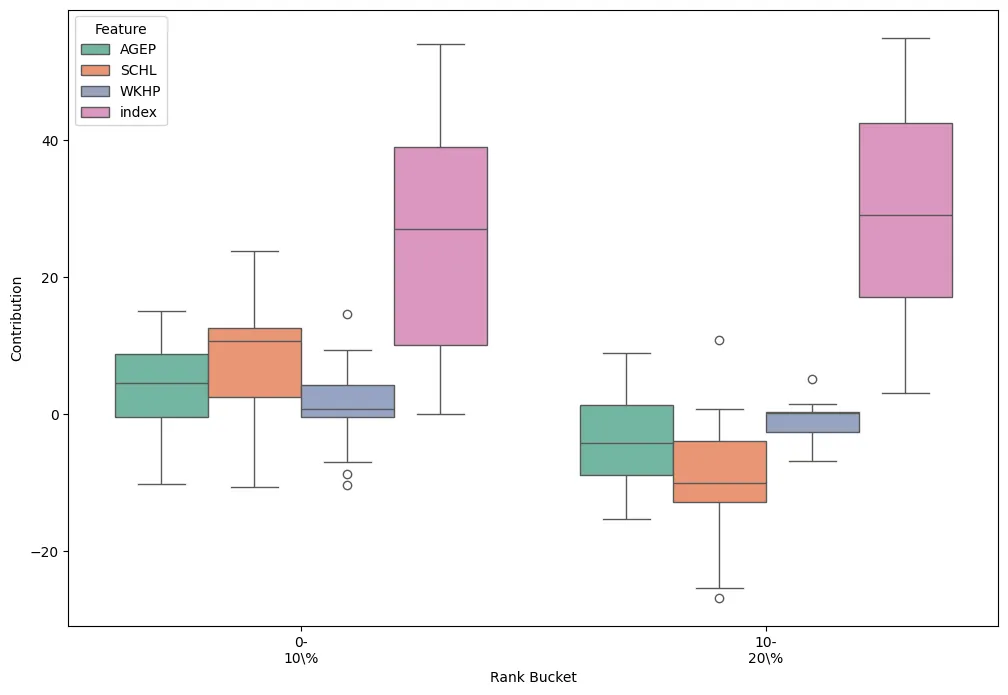

### Part (iii)
Compare feature importance between the 0-10% and 10-20% for each racial group
When comparing the 0-10% and 10-20% strata within the top applicants:

For the 0-10% stratum (higher ranked individuals):

SCHL (education) has a strong positive contribution, with most values being positive
AGEP (age) generally has a moderate positive contribution
WKHP (work hours) shows a small positive contribution
The index feature (representing the individuals) has the largest variance and overall contribution


For the 10-20% stratum (lower ranked individuals):

SCHL has shifted to a negative contribution, suggesting education is less favorable for these individuals
AGEP also shows a negative trend
WKHP remains relatively neutral but slightly negative
The index feature continues to have the largest variance and strongest positive impact



The most notable difference between strata is the reversal in contribution direction for SCHL and AGEP - features that contribute positively to ranking for the top 10% contribute negatively for the next 10%. This indicates a clear stratification effect where the importance and impact of features change significantly across different ranking tiers.


### Part (iv) - Compare feature importance across racial groups
This boxplot appears to represent feature importance for one racial group (either white or non-white). Without seeing the comparison plot for the other racial group, I can make these observations about potential cross-racial differences:

The significant positive contribution of SCHL in the top 10% and its negative contribution in the 10-20% range suggests a strong emphasis on education in the ranking model. This could potentially create disparate impacts if educational attainment differs between racial groups.
The shift in AGEP's contribution between strata could also have differential impacts on racial groups with different age distributions.
The relatively small contribution of WKHP might be more equitable across racial groups, assuming work hours are more evenly distributed.
The large variance in the index feature suggests considerable heterogeneity among individuals within each group, which could either amplify or mask racial differences.

In general, whenever a feature's importance varies significantly across ranking tiers, there's potential for disparate impact if the underlying feature distributions differ between racial groups. The dramatic shift in SCHL's importance between tiers would be particularly concerning if educational attainment differs systematically by race.

# Part (c)

Now we will try to compare the feature importance of two separate people (the 200th and the 300th). Select two samples and calculate their individual feature contributions under any QoI. Like in the question above, fix the ranking function to the first one to do so. Late visualize a way to explain why one is ranked higher than the other!

**Note:** use the full dataset (not the datasets for each race) and use the `score_function_SCHL` ranker.

Individual at rank 200 has index: 522
Individual at rank 300 has index: 383


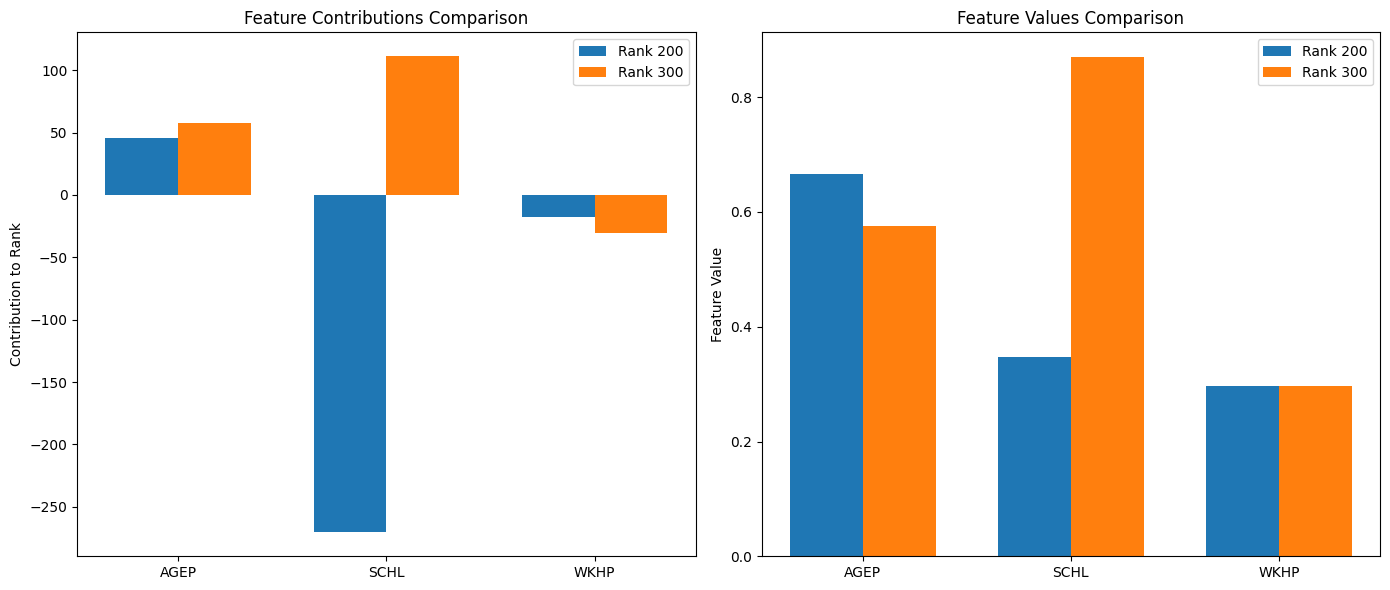

In [29]:
# --- Part (c) Fixed ---

# Construct feature matrix X using only relevant numerical columns
feature_names = ['AGEP', 'SCHL', 'WKHP']
X = data[feature_names].to_numpy()

# Ensure ShaRP is fitted
sharp_ranking_SCHL.fit(X)

# Select the index of the 200th and 300th ranked individuals
i200 = order_SCHL[199]
i300 = order_SCHL[299]
print(f"Individual at rank 200 has index: {i200}")
print(f"Individual at rank 300 has index: {i300}")

# Get all explanations
all_explanations_SCHL = sharp_ranking_SCHL.all(X)

# Extract contributions
contributions_i200 = all_explanations_SCHL[i200]
contributions_i300 = all_explanations_SCHL[i300]

# Plot bar chart comparison
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
x_pos = np.arange(len(feature_names))
width = 0.35

# Bar chart - contributions
ax[0].bar(x_pos - width/2, contributions_i200, width, label='Rank 200')
ax[0].bar(x_pos + width/2, contributions_i300, width, label='Rank 300')
ax[0].set_ylabel('Contribution to Rank')
ax[0].set_title('Feature Contributions Comparison')
ax[0].set_xticks(x_pos)
ax[0].set_xticklabels(feature_names)
ax[0].legend()

# Feature values
feature_values_i200 = X[i200]
feature_values_i300 = X[i300]

# Bar chart - actual feature values
ax[1].bar(x_pos - width/2, feature_values_i200, width, label='Rank 200')
ax[1].bar(x_pos + width/2, feature_values_i300, width, label='Rank 300')
ax[1].set_ylabel('Feature Value')
ax[1].set_title('Feature Values Comparison')
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels(feature_names)
ax[1].legend()

plt.tight_layout()
plt.show()
